In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

data = pd.read_csv('final_shuffled.csv')

X = data.drop(columns=['subject_id', 'label'])
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data loaded.")
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")

Data loaded.
Training data has 320 rows.
Test data has 80 rows.


/Users/shubham/Desktop/PROJECTS/HACKWELL_PROJECT/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AUROC: 0.7728
AUPRC: 0.7249


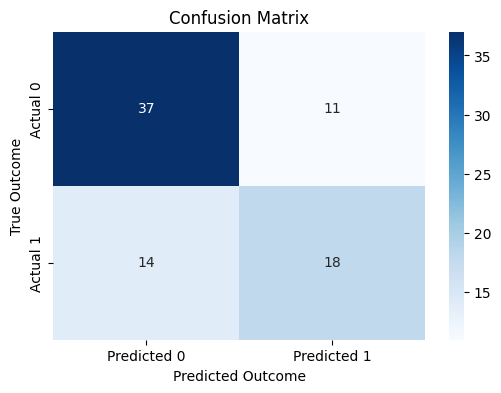

/var/folders/m1/00hnz85n66gbxg871241zmt80000gn/T/ipykernel_10989/2061541828.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib_df = test_df.groupby('prob_bin').agg(


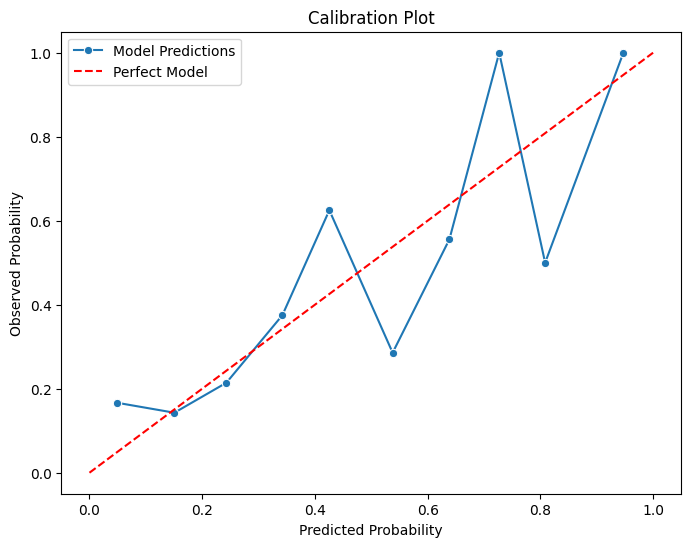

In [2]:
model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]
preds = (probs > 0.5).astype(int)

auroc = roc_auc_score(y_test, probs)
print(f"AUROC: {auroc:.4f}")

prec, rec, _ = precision_recall_curve(y_test, probs)
auprc = auc(rec, prec)
print(f"AUPRC: {auprc:.4f}")

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

test_df = X_test.copy()
test_df['true'] = y_test
test_df['prob'] = probs
test_df['prob_bin'] = pd.cut(test_df['prob'], bins=10, labels=np.arange(10))
calib_df = test_df.groupby('prob_bin').agg(
    count=('true', 'size'),
    mean_prob=('prob', 'mean'),
    mean_true=('true', 'mean')
).dropna().reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(x='mean_prob', y='mean_true', data=calib_df, marker='o', label='Model Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Model')
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()
plt.show()

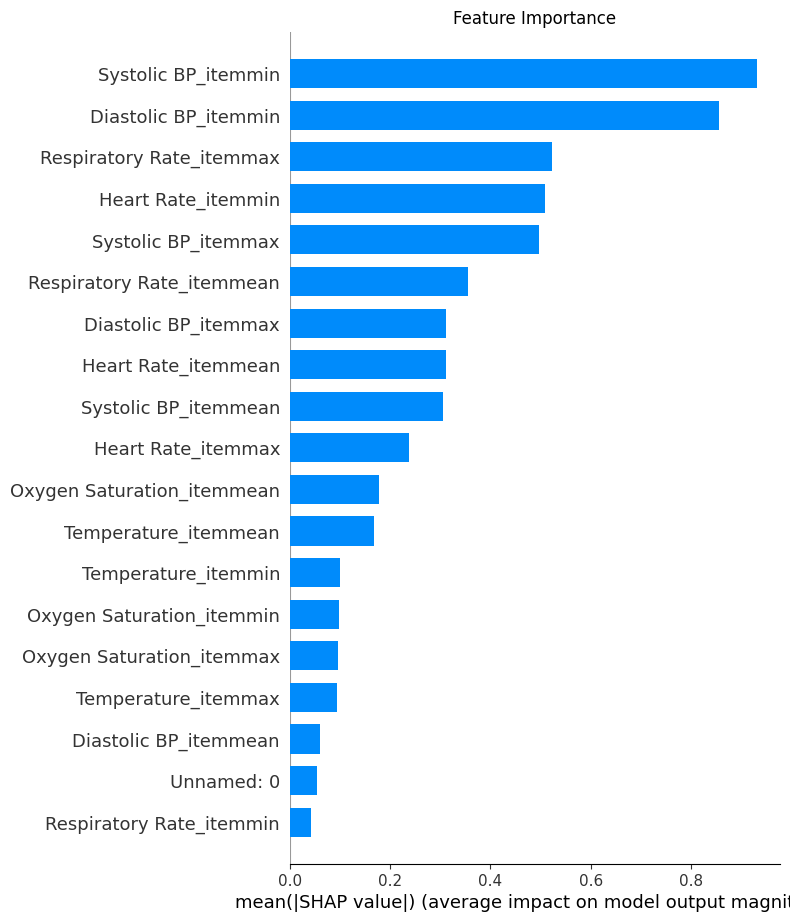


Analyzing patient 19's prediction.
The model predicts a 44.50% chance of deterioration.
The actual outcome was 0.


Top factors that increased risk:
  • Systolic BP was 142.5, which increased risk.
  • Respiratory Rate was 19.6, which increased risk.
  • Oxygen Saturation was 99.2, which increased risk.

Top factors that reduced risk:
  • Diastolic BP was 63.5, which decreased risk.
  • Systolic BP was 145.9, which decreased risk.
  • Diastolic BP was 61.6, which decreased risk.


In [3]:
explainer = shap.LinearExplainer(model, X_train)
shap_vals = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, plot_type="bar", show=False)
plt.title('Feature Importance')
plt.show()

patient_idx = np.random.randint(0, len(X_test))
patient_data = X_test.iloc[[patient_idx]]
true_label = y_test.iloc[patient_idx]
pred_prob = model.predict_proba(patient_data)[:, 1][0]

print(f"\nAnalyzing patient {patient_idx}'s prediction.")
print(f"The model predicts a {pred_prob:.2%} chance of deterioration.")
print(f"The actual outcome was {true_label}.")

shap.initjs()
shap_patient = explainer.shap_values(patient_data)
shap.force_plot(explainer.expected_value, shap_patient, patient_data, show=False)

def explain_patient(data, shap_vals, num_features=3):
    contribs = pd.DataFrame({
        'feature': data.columns,
        'value': data.iloc[0].values,
        'contribution': shap_vals[0]
    }).sort_values(by='contribution', ascending=False)

    top_drivers = contribs.head(num_features)
    bottom_drivers = contribs.tail(num_features)

    print("Top factors that increased risk:")
    for _, row in top_drivers.iterrows():
        print(f"  • {row['feature'].split('_')[0]} was {row['value']:.1f}, which increased risk.")

    print("\nTop factors that reduced risk:")
    for _, row in bottom_drivers.iterrows():
        print(f"  • {row['feature'].split('_')[0]} was {row['value']:.1f}, which decreased risk.")

explain_patient(patient_data, shap_patient)

In [4]:
results = pd.DataFrame({
    'patient_id': X_test.index,
    'pred_prob': probs,
    'risk_band': pd.cut(probs, bins=[0, 0.2, 0.5, 1.0], labels=['Low', 'Medium', 'High']),
    'actual_outcome': y_test.values
})
print("\n--- Summary of All Patients (First 10) ---")
print(results.head(10).to_markdown(index=False))

def get_patient_details(patient_id):
    patient_data = X_test.loc[[patient_id]]
    pred_prob = results.loc[results['patient_id'] == patient_id, 'pred_prob'].values[0]

    print(f"\n--- Patient Details for Patient {patient_id} ---")
    print(f"Risk of Deterioration: {pred_prob:.2%}")
    print(f"Risk Level: {results.loc[results['patient_id'] == patient_id, 'risk_band'].values[0]}")

    shap_patient = explainer.shap_values(patient_data)
    explain_patient(patient_data, shap_patient)

    print("\nNext Steps:")
    print("  • Review recent lab results.")
    print("  • Schedule a follow-up.")
    print("  • Discuss recent medication changes.")

get_patient_details(results['patient_id'].iloc[0])


--- Summary of All Patients (First 10) ---
|   patient_id |   pred_prob | risk_band   |   actual_outcome |
|-------------:|------------:|:------------|-----------------:|
|          365 |    0.846729 | High        |                1 |
|          397 |    0.552969 | High        |                0 |
|          324 |    0.648179 | High        |                0 |
|           73 |    0.205979 | Medium      |                0 |
|          312 |    0.774313 | High        |                0 |
|          391 |    0.789143 | High        |                0 |
|          355 |    0.605083 | High        |                1 |
|          119 |    0.532838 | High        |                0 |
|          113 |    0.162779 | Low         |                0 |
|           89 |    0.254584 | Medium      |                0 |

--- Patient Details for Patient 365 ---
Risk of Deterioration: 84.67%
Risk Level: High
Top factors that increased risk:
  • Systolic BP was 190.5, which increased risk.
  • Diastolic BP w

In [5]:
from sklearn.metrics import classification_report


print("Classification Report:")
print(classification_report(y_test, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        48
           1       0.62      0.56      0.59        32

    accuracy                           0.69        80
   macro avg       0.67      0.67      0.67        80
weighted avg       0.68      0.69      0.68        80

